In [ ]:
!pip install pgmpy==0.1.21 networkx matplotlib pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 38.9 MB/s eta 0:00:00


In [ ]:
from pgmpy.models import BayesianModel as DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
if not hasattr(np, "product"):
    np.product = np.prod

In [ ]:
# 1. Define the model structure
model = DiscreteBayesianNetwork([('C','W'), ('T','W'), ('T','I'), ('S','I'), ('W','J'), ('I','J')])

In [ ]:
# 2. Define CPDs (with state names)
cpd_C = TabularCPD(variable='C', variable_card=3,
                   values=[[0.2], [0.5], [0.3]],
                   state_names={'C': ['Low','Medium','High']})

In [ ]:
cpd_T = TabularCPD(variable='T', variable_card=2,
                   values=[[0.4], [0.6]],
                   state_names={'T': ['Weak','Strong']})

In [ ]:
cpd_S = TabularCPD(variable='S', variable_card=2,
                   values=[[0.5], [0.5]],
                   state_names={'S': ['Weak','Strong']})

In [ ]:
written_cpd = TabularCPD(variable='W', variable_card=2,
    values =[[0.8 , 0.6, 0.3, 0.4, 0.2, 0.1],
             [0.2, 0.4, 0.7, 0.6, 0.8, 0.9]],
    evidence =['C', 'T'], evidence_card =[3, 2],
    state_names ={'W': ['Fail','Pass'], 'C': ['Low','Medium','High'], 'T': ['Weak','Strong']})

In [ ]:
interview_cpd = TabularCPD(variable='I', variable_card =2,
    values =[[0.7 , 0.4, 0.3, 0.1],
             [0.3, 0.6, 0.7, 0.9]],
    evidence =['T', 'S'], evidence_card =[2, 2],
    state_names ={'I': ['Fail','Pass'], 'T': ['Weak','Strong'], 'S': ['Weak','Strong']})

In [ ]:
offer_cpd = TabularCPD(variable='J', variable_card =2,
    values =[[0.99 , 0.8, 0.6, 0.1],
             [0.01, 0.2, 0.4, 0.9]],
    evidence =['W', 'I'], evidence_card =[2, 2],
    state_names ={'J': ['No','Yes'], 'W': ['Fail','Pass'], 'I': ['Fail','Pass']})

In [ ]:
# Add CPDs to model
model.add_cpds(cpd_C, cpd_T, cpd_S, written_cpd, interview_cpd, offer_cpd)

In [ ]:
# Check model
assert model.check_model(), "Model failed consistency checks."

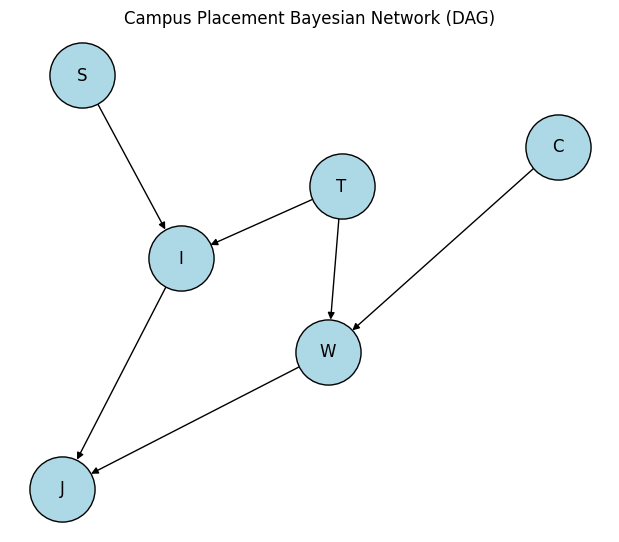

In [ ]:
# Visualize graph
G = nx.DiGraph()
G.add_edges_from(model.edges())
pos = nx.spring_layout(G, seed=42)   # ✅ pass the graph, not its edges
plt.figure(figsize=(6,5))
nx.draw(G, pos, with_labels=True, arrows=True,
        node_size=2200, node_color='lightblue', edgecolors='black')
plt.title('Campus Placement Bayesian Network (DAG)')
plt.show()

In [ ]:
# Inference
infer = VariableElimination(model)

In [ ]:
# 1. Baseline P(J)
pj = infer.query(['J'])
print("1) Baseline P(J):")
print(pj, "\n")

1) Baseline P(J):
+--------+----------+
| J      |   phi(J) |
+========+==========+
| J(No)  |   0.4823 |
+--------+----------+
| J(Yes) |   0.5177 |
+--------+----------+ 



In [ ]:
# 2. Predictive: P(J | C=High, T=Strong)
pj_given = infer.query(['J'], evidence={'C':'High','T':'Strong'})
print("2) P(J | C=High, T=Strong):")
print(pj_given, "\n")

2) P(J | C=High, T=Strong):
+--------+----------+
| J      |   phi(J) |
+========+==========+
| J(No)  |   0.2638 |
+--------+----------+
| J(Yes) |   0.7362 |
+--------+----------+ 



In [ ]:
# 3. Diagnostic: P(T | J=Yes)
pt_given_j = infer.query(['T'], evidence={'J':'Yes'})
print("3) P(T | J=Yes):")
print(pt_given_j, "\n")

3) P(T | J=Yes):
+-----------+----------+
| T         |   phi(T) |
+===========+==========+
| T(Weak)   |   0.3316 |
+-----------+----------+
| T(Strong) |   0.6684 |
+-----------+----------+ 



In [ ]:
# 4a Explaining-away: P(W=Pass | J=Yes)
pw_given_j = infer.query(['W'], evidence={'J':'Yes'})
print("4a) P(W | J=Yes):")
print(pw_given_j, "\n")

4a) P(W | J=Yes):
+---------+----------+
| W       |   phi(W) |
+=========+==========+
| W(Fail) |   0.0930 |
+---------+----------+
| W(Pass) |   0.9070 |
+---------+----------+ 



In [ ]:
# 4b Explaining-away: P(W=Pass | J=Yes, I=Pass)
pw_given_j_i = infer.query(['W'], evidence={'J':'Yes','I':'Pass'})
print("4b) P(W | J=Yes, I=Pass):")
print(pw_given_j_i, "\n")

4b) P(W | J=Yes, I=Pass):
+---------+----------+
| W       |   phi(W) |
+=========+==========+
| W(Fail) |   0.1092 |
+---------+----------+
| W(Pass) |   0.8908 |
+---------+----------+ 



In [ ]:
# 5. Parameter Learning
print("Generating 20,000 samples (this may take a few seconds)...")
data = model.simulate(n_samples=20000, seed=42)
print("Sample head:")
print(data.head(), "\n")

Generating 20,000 samples (this may take a few seconds)...


  0%|          | 0/6 [00:00<?, ?it/s]

Sample head:
        C     I     W    J       T     S
0  Medium  Pass  Fail   No  Strong  Weak
1    High  Pass  Pass  Yes    Weak  Weak
2    High  Fail  Pass  Yes    Weak  Weak
3  Medium  Pass  Pass  Yes  Strong  Weak
4     Low  Fail  Pass   No  Strong  Weak 



/usr/local/lib/python3.12/dist-packages/pgmpy/sampling/base.py:550: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pandas.DataFrame.from_records(samples)


In [ ]:
learned_model = DiscreteBayesianNetwork([('C','W'), ('T','W'), ('T','I'), ('S','I'), ('W','J'), ('I','J')])

/usr/local/lib/python3.12/dist-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


In [ ]:
learned_model.fit(data)

In [ ]:
learned_j_cpd = learned_model.get_cpds('J')

In [ ]:
print("Learned CPD for J (P(J|W,I)):\n")
print(learned_j_cpd, "\n")
print("Original CPD for J (P(J|W,I)):\n")
print(offer_cpd, "\n")

Learned CPD for J (P(J|W,I)):

+--------+----------------------+-----+---------------------+
| I      | I(Fail)              | ... | I(Pass)             |
+--------+----------------------+-----+---------------------+
| W      | W(Fail)              | ... | W(Pass)             |
+--------+----------------------+-----+---------------------+
| J(No)  | 0.9923541247484909   | ... | 0.09964454976303318 |
+--------+----------------------+-----+---------------------+
| J(Yes) | 0.007645875251509054 | ... | 0.9003554502369668  |
+--------+----------------------+-----+---------------------+ 

Original CPD for J (P(J|W,I)):

+--------+---------+---------+---------+---------+
| W      | W(Fail) | W(Fail) | W(Pass) | W(Pass) |
+--------+---------+---------+---------+---------+
| I      | I(Fail) | I(Pass) | I(Fail) | I(Pass) |
+--------+---------+---------+---------+---------+
| J(No)  | 0.99    | 0.8     | 0.6     | 0.1     |
+--------+---------+---------+---------+---------+
| J(Yes) | 0.01    |

In [ ]:
# For numeric comparison:
orig_yes = offer_cpd.values[1].flatten()  # row for J=Yes
learn_yes = learned_j_cpd.values[1].flatten()

In [ ]:
combos = [('W=Fail','I=Fail'), ('W=Pass','I=Fail'), ('W=Fail','I=Pass'), ('W=Pass','I=Pass')]

In [ ]:
comparison = pd.DataFrame({
    'combo': combos,
    'original_P(J=Yes)': np.round(orig_yes,4),
    'learned_P(J=Yes)': np.round(learn_yes,4)
})

In [ ]:
print("Comparison P(J=Yes) by (W,I):")
print(comparison.to_string(index=False))

Comparison P(J=Yes) by (W,I):
           combo  original_P(J=Yes)  learned_P(J=Yes)
(W=Fail, I=Fail)               0.01            0.0076
(W=Pass, I=Fail)               0.20            0.4039
(W=Fail, I=Pass)               0.40            0.2115
(W=Pass, I=Pass)               0.90            0.9004
